In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# FMCW Radar with Motion Planning

## Introduction

This example demonstrates how to simulate a **moving radar platform** using RadarSimPy's motion planning capabilities. In many real-world scenarios, the radar itself is in motion—mounted on vehicles, drones, robots, or ships. Understanding how platform motion affects radar measurements is crucial for applications like:

- **Automotive radar**: Self-driving cars with moving radar sensors
- **Airborne radar**: Aircraft or UAV-based radar systems
- **Mobile robotics**: Autonomous robots with radar for navigation
- **Marine radar**: Ship-based radar systems

**What You'll Learn:**

- How to configure **arbitrary radar platform motion** using `radar.set_motion()`
- Creating complex trajectories (linear, sinusoidal, circular, accelerated, etc.)
- Understanding relative motion between radar and targets
- How platform motion creates apparent Doppler shifts
- Analyzing Range-Doppler maps with a moving radar

### Radar Platform Motion in RadarSimPy

RadarSimPy allows you to define **arbitrary time-varying radar positions and orientations** throughout the observation period. The `radar.set_motion()` method accepts:

- **location**: Position as a **function of time** (x, y, z coordinates) - array sampled at each timestamp
- **rotation**: Orientation as a **function of time** (yaw, pitch, roll angles in radians) - array sampled at each timestamp
- **speed**: Constant velocity offset (vx, vy, vz) - **must be (0, 0, 0) when using motion planning**
- **rotation_rate**: Constant angular velocity offset - **must be (0, 0, 0) when using motion planning**

**Important**: When using motion planning (time-varying arrays for location/rotation):

- Set `speed=(0, 0, 0)` - all motion should be encoded in the `location` array
- Set `rotation_rate=(0, 0, 0)` - all rotation should be encoded in the `rotation` array
- This ensures motion is fully controlled by your time-sampled trajectories

**Key Feature**: The motion is defined by providing position and rotation arrays sampled at each **sample timestamp** (every ADC sample). This means you can create:

- Simple linear trajectories
- Complex curved paths
- Oscillating/vibrating platforms
- Accelerating or decelerating motion
- Time-varying orientations (rotating, pitching, rolling platforms)
- Any trajectory expressible as a mathematical function of time

**High-Fidelity Simulation**: Unlike systems that only update position pulse-to-pulse, RadarSimPy evaluates motion at every sample within each pulse, providing accurate simulation of fast-changing dynamics.

In this example, we'll demonstrate multiple motion patterns, starting with linear motion along the x-axis while observing a stationary corner reflector target.

### Quick FMCW Radar Review

FMCW (Frequency-Modulated Continuous Wave) radar continuously transmits a frequency-swept signal. Key characteristics:

- **Range measurement**: Determined by the beat frequency between transmitted and received signals
- **Velocity measurement**: Derived from Doppler shift across multiple pulses
- **Relative motion**: Both target motion AND radar motion contribute to observed Doppler

**Important**: When the radar platform moves, it creates Doppler shifts even for stationary targets. The observed Doppler shift is based on the **relative velocity** between radar and target.

## Create Radar Model

First, import the required modules from `radarsimpy`. We'll also need `numpy` for motion trajectory calculations.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Transmitter

Setup the basic transmitter parameters through the [Transmitter](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter) module.

#### Define a Radar Transmitter

For FMCW radar, the waveform is defined using frequency sweep parameters:

- **`f = [fstart, fend]`**: Frequency sweep range (e.g., 76.95 to 77.05 GHz = 100 MHz bandwidth)
- **`t = [tstart, tend]`**: Chirp duration (time for one frequency sweep)
- **`prp`**: Pulse Repetition Period (time between consecutive chirps)
- **`pulses`**: Number of chirps in the coherent processing interval (CPI)

The diagram below illustrates the FMCW waveform structure:

```
|                       prp
|                  +-----------+
|
|            +---f[1]--->  /            /            /
|                         /            /            /
|                        /            /            /
|                       /            /            /
|                      /            /            /     ...
|                     /            /            /
|                    /            /            /
|                   /            /            /
|      +---f[0]--->/            /            /
|
|                  +-------+
|                 t[0]    t[1]
```

**Configuration for this example:**

- Center frequency: 77 GHz (automotive radar band)
- Bandwidth: 100 MHz (76.95 - 77.05 GHz)
- 256 pulses allows for fine Doppler resolution


In [3]:
# Define transmitter channel at the origin
tx_channel = dict(
    location=(0, 0, 0),  # Initial position (will move according to motion plan)
)

# Create FMCW transmitter
tx = Transmitter(
    f=[77e9 - 50e6, 77e9 + 50e6],  # 76.95 to 77.05 GHz (100 MHz bandwidth)
    t=[0, 80e-6],  # 80 microsecond chirp duration
    tx_power=25,  # 25 dBm transmit power (~316 mW)
    prp=100e-6,  # 100 microsecond pulse repetition period
    pulses=256,  # 256 pulses for Doppler processing
    channels=[tx_channel],
)

### Receiver

Setup the receiver parameters through the [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.

#### Define a Radar Receiver

The receiver configuration determines system sensitivity and noise performance:

- **`fs`**: Sampling rate (samples per second) - determines maximum unambiguous range
- **`noise_figure`**: Noise figure in dB - degrades SNR by adding receiver noise
- **`rf_gain`**: RF amplifier gain in dB
- **`load_resistor`**: Load resistor value (Ohms) for power-to-voltage conversion
- **`baseband_gain`**: Baseband amplifier gain in dB


In [4]:
# Define receiver channel co-located with transmitter
rx_channel = dict(
    location=(0, 0, 0),  # Monostatic configuration (TX and RX at same location)
)

# Create receiver with specified noise and gain parameters
rx = Receiver(
    fs=2e6,  # 2 MHz sampling rate
    noise_figure=8,  # 8 dB noise figure
    rf_gain=20,  # 20 dB RF gain
    load_resistor=500,  # 500 Ohm load resistor
    baseband_gain=30,  # 30 dB baseband gain
    channels=[rx_channel],
)

### Radar System with Motion Planning

Create the radar system and configure its motion trajectory using `radar.set_motion()`.

#### Understanding Radar Motion

The key feature demonstrated here is **platform motion planning**. Instead of a stationary radar, we simulate a radar that moves during the observation period.

**Flexible Motion Configuration:**

RadarSimPy's motion planning is **not limited to simple linear motion**. You can define **arbitrary, complex trajectories** by specifying position (and optionally rotation) as a function of time. The motion is sampled at each **sample timestamp** (not just pulse-to-pulse), allowing:

- **Linear motion**: Constant velocity movement (as shown in this example)
- **Sinusoidal motion**: Oscillating trajectories for vibration analysis
- **Circular motion**: Rotating radar platforms
- **Accelerated motion**: Time-varying velocities
- **Rotating platforms**: Time-varying orientation (roll, pitch, yaw)
- **Arbitrary paths**: Any mathematically defined trajectory you can express as a function of time

**Key Principles:**

- `radar.time_prop["timestamp"]` is a numpy array containing the time sample for each ADC sample (not just each pulse)
- Position is evaluated at **every sample timestamp**, providing high-fidelity motion simulation
- **Location** can be **any function of these timestamps**: `location = f(timestamp)`
- **Rotation** can also be **any function of these timestamps**: `rotation = g(timestamp)`
- When using motion planning arrays, **both `speed` and `rotation_rate` must be set to (0, 0, 0)**
- This ensures all motion is controlled by your time-sampled trajectories, not mixed with constant offsets

This enables realistic simulation of complex platform dynamics (vehicles turning, drones maneuvering, etc.)


In [5]:
# Create radar system from transmitter and receiver
radar = Radar(transmitter=tx, receiver=rx)

# The timestamp array contains the time value for EACH SAMPLE (not just each pulse)
# This allows high-fidelity motion simulation where position is updated at every ADC sample
# You can use this to define ANY arbitrary motion trajectory as a function of time
timestamps = radar.time_prop["timestamp"]

# Note: timestamps.shape = (frames × channels, pulses, samples_per_pulse)
# Motion is evaluated at each of these timestamps for accurate simulation

# ============================================================================
# EXAMPLE MOTION PATTERNS - Uncomment any to try different trajectories
# ============================================================================

# Option 1: Linear motion at constant velocity (ACTIVE)
# Simple constant velocity motion along x-axis
location_x = -12 * timestamps  # Moving at -12 m/s
location_y = 0 * timestamps  # No y motion
location_z = 0 * timestamps  # No z motion

# Option 2: Sinusoidal motion (UNCOMMENT TO TRY)
# Oscillating motion - useful for vibration/jitter analysis
# location_x = 10 * np.sin(2 * np.pi * timestamps)  # Oscillate with 1 Hz
# location_y = 0 * timestamps
# location_z = 0 * timestamps

# Option 3: Circular motion (UNCOMMENT TO TRY)
# Radar moving in a circle - simulates rotating platform
# radius = 20
# angular_freq = 2 * np.pi * 0.5  # 0.5 Hz rotation
# location_x = 30 + radius * np.cos(angular_freq * timestamps)
# location_y = radius * np.sin(angular_freq * timestamps)
# location_z = 0 * timestamps

# Option 4: Accelerated motion (UNCOMMENT TO TRY)
# Non-uniform velocity - simulates vehicle acceleration
# acceleration = 5  # m/s^2
# location_x = 0.5 * acceleration * timestamps**2
# location_y = 0 * timestamps
# location_z = 0 * timestamps

# Option 5: Complex trajectory (UNCOMMENT TO TRY)
# Combine multiple components for realistic vehicle motion
# location_x = -12 * timestamps + 2 * np.sin(4 * np.pi * timestamps)  # Linear + oscillation
# location_y = 3 * np.sin(2 * np.pi * timestamps)  # Side-to-side motion
# location_z = 0 * timestamps

# Option 6: Motion with rotation (UNCOMMENT TO TRY)
# Radar translating and rotating - simulates vehicle turning
# location_x = -12 * timestamps
# location_y = 0 * timestamps
# location_z = 0 * timestamps
# rotation_yaw = 0.5 * timestamps  # Yaw: rotating at 0.5 rad/s
# rotation_pitch = 0 * timestamps  # Pitch: no pitching
# rotation_roll = 0 * timestamps   # Roll: no rolling
# rotation = (rotation_yaw, rotation_pitch, rotation_roll)  # Order: (yaw, pitch, roll)

# ============================================================================

# Apply motion plan to radar
# IMPORTANT: When using motion planning (time-varying location/rotation arrays),
# both speed and rotation_rate MUST be set to (0, 0, 0)
# All motion should be encoded in the location and rotation arrays
radar.set_motion(
    location=(location_x, location_y, location_z),
    speed=(0, 0, 0),  # MUST be (0,0,0) when using motion planning arrays
    # rotation=(rotation_yaw, rotation_pitch, rotation_roll),  # Optional: add rotation (yaw, pitch, roll)
    # rotation_rate=(0, 0, 0),  # MUST be (0,0,0) when using motion planning arrays
)

# Note: With linear motion at -12 m/s in the negative x direction:
# - Radar starts at x=0 and moves in negative x direction (away from target at x=50m)
# - Target is stationary at x=50m (positive x direction)
# - This creates opening geometry, producing positive Doppler shift

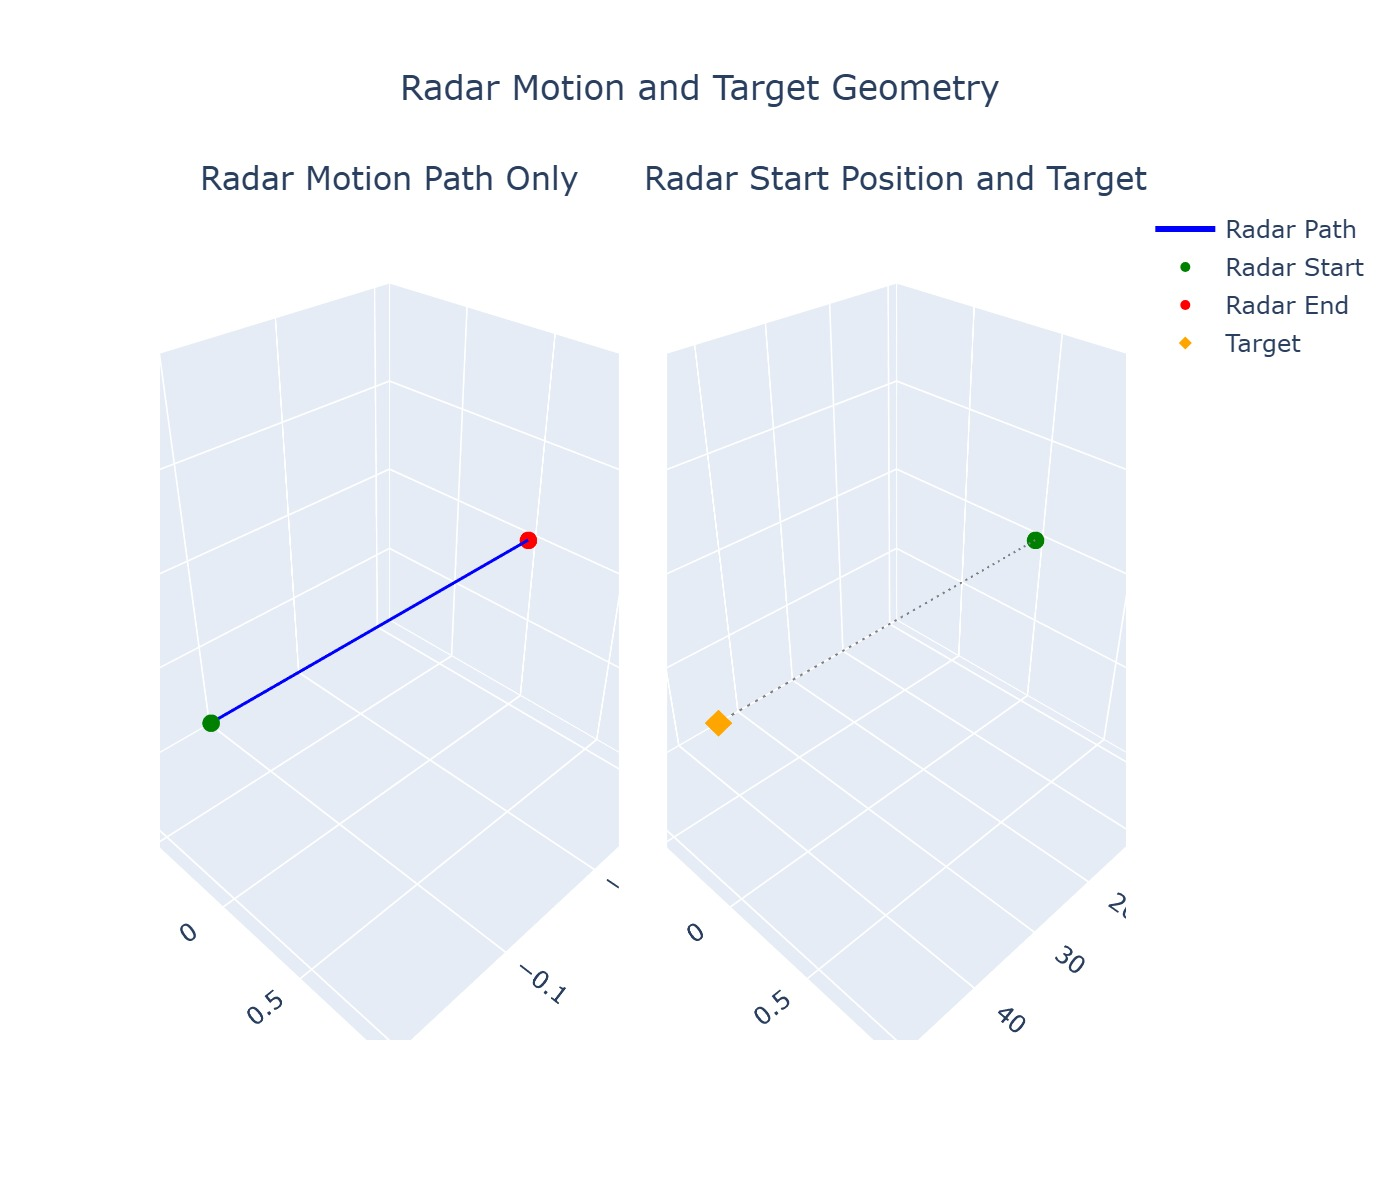

In [29]:
import plotly.graph_objs as go
from IPython.display import Image
from plotly.subplots import make_subplots

# Extract the motion path (take the trajectory from the first frame/channel)
# location arrays have shape (1, 256, 160), we'll plot the path across all pulses and samples
motion_x = location_x.flatten()
motion_y = location_y.flatten()
motion_z = location_z.flatten()

# Create subplots: radar motion only (left) and radar start + target (right)
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{"type": "scene"}, {"type": "scene"}]],
    subplot_titles=("Radar Motion Path Only", "Radar Start Position and Target"),
    horizontal_spacing=0.05,
)

# ============ LEFT PLOT: Radar Motion Only ============

# Plot the motion trajectory
fig.add_trace(
    go.Scatter3d(
        x=motion_x,
        y=motion_y,
        z=motion_z,
        mode="lines",
        line=dict(color="blue", width=3),
        name="Radar Path",
        showlegend=True,
    ),
    row=1,
    col=1,
)

# Mark start position
fig.add_trace(
    go.Scatter3d(
        x=[motion_x[0]],
        y=[motion_y[0]],
        z=[motion_z[0]],
        mode="markers+text",
        marker=dict(size=5, color="green", symbol="circle"),
        name="Radar Start",
        showlegend=True,
    ),
    row=1,
    col=1,
)

# Mark end position
fig.add_trace(
    go.Scatter3d(
        x=[motion_x[-1]],
        y=[motion_y[-1]],
        z=[motion_z[-1]],
        mode="markers+text",
        marker=dict(size=5, color="red", symbol="circle"),
        name="Radar End",
        showlegend=True,
    ),
    row=1,
    col=1,
)

# ============ RIGHT PLOT: Radar Start + Target ============

# Mark radar start position
fig.add_trace(
    go.Scatter3d(
        x=[motion_x[0]],
        y=[motion_y[0]],
        z=[motion_z[0]],
        mode="markers+text",
        marker=dict(size=5, color="green", symbol="circle"),
        name="Radar Start",
        showlegend=False,
    ),
    row=1,
    col=2,
)

# Mark target position
fig.add_trace(
    go.Scatter3d(
        x=[50],
        y=[0],
        z=[0],
        mode="markers+text",
        marker=dict(size=5, color="orange", symbol="diamond"),
        name="Target",
        showlegend=True,
    ),
    row=1,
    col=2,
)

# Add line showing initial range from radar to target
fig.add_trace(
    go.Scatter3d(
        x=[motion_x[0], 50],
        y=[motion_y[0], 0],
        z=[motion_z[0], 0],
        mode="lines",
        line=dict(color="gray", width=2, dash="dash"),
        name="Initial Range",
        showlegend=False,
    ),
    row=1,
    col=2,
)

# Update layout for both scenes
fig.update_layout(
    title={"text": "Radar Motion and Target Geometry", "x": 0.5, "xanchor": "center"},
    scene=dict(
        xaxis=dict(title="X (m)"),
        yaxis=dict(title="Y (m)"),
        zaxis=dict(title="Z (m)"),
        aspectmode="cube",
    ),
    scene2=dict(
        xaxis=dict(title="X (m)"),
        yaxis=dict(title="Y (m)"),
        zaxis=dict(title="Z (m)"),
        aspectmode="cube",
    ),
    height=600,
    showlegend=True,
    # legend=dict(x=0.02, y=0.98),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

**Try Different Motion Patterns:**

The code cell below includes several motion pattern examples. The linear motion is currently active. To try other patterns:

1. Comment out the active motion pattern (lines with `location_x = -12 * timestamps`)
2. Uncomment one of the other options (sinusoidal, circular, accelerated, or complex)
3. Re-run the simulation to see how different motion affects the Range-Doppler map

Each pattern demonstrates that motion planning is **not limited to simple linear trajectories** - you can define any arbitrary motion as a function of the time samples.


## Target Configuration

Define a stationary corner reflector target at a fixed position.

**Key Point**: The target is stationary (speed = 0), but due to the radar's motion, there will be a **relative velocity** between the radar and target. This relative motion will appear as a Doppler shift in the Range-Doppler map.


In [6]:
# Define stationary corner reflector target
target_1 = {
    "model": "../models/cr.stl",  # 3D mesh model of trihedral corner reflector
    "unit": "m",  # Units for the model
    "location": (50, 0, 0),  # Fixed position at x=50m, y=0, z=0
    "speed": (0, 0, 0),  # Stationary target (no motion)
}

targets = [target_1]

# Geometry: Radar starts at origin (0,0,0) and moves in -x direction (away from target)
#           Target stays at (50,0,0) in the positive x direction
# Result: Radar moves away from the target, creating positive range rate (opening)

## Radar Scene Simulation

Use the `simulator.sim_radar` module to simulate baseband samples incorporating:

- Radar platform motion (defined by `set_motion`)
- Target reflections with appropriate range and Doppler
- Receiver noise and system characteristics

The simulation accounts for the time-varying geometry as the radar moves, accurately computing the changing range and Doppler shift for each pulse.

**Important for Motion Planning with Mesh Targets:**

When using **3D mesh models** as targets (like the corner reflector STL file), ray tracing is performed to compute reflections. With radar motion planning, the fidelity level **must be set to `level="sample"`** to properly evaluate the arbitrary motion at each timestamp. This ensures:

- Accurate ray tracing at every sample timestamp
- Correct geometry calculations for time-varying radar position
- Proper phase relationships for moving platforms

**Trade-off**: Setting `level="sample"` significantly increases simulation time because ray tracing must be performed at each timestamp rather than once per pulse. This is necessary for high-fidelity motion simulation but results in longer computation times.

**Note**: This `level="sample"` requirement **only applies to 3D mesh targets** that use ray tracing. For **ideal point targets**, motion planning works without this restriction, and the simulation can use the default fidelity level with faster computation times.

**Output Structure:**

The returned data dictionary contains:

- **`timestamp`**: Time values for each pulse
- **`baseband`**: Target return signals (3D array: [channels, pulses, ADC samples])
- **`noise`**: Receiver noise (separate for analysis flexibility)

**Simulation Parameters:**

- `density=0.2`: Ray density for mesh target simulation (controls ray tracing resolution)
- `level="sample"`: **Required for motion planning with mesh targets** - evaluates geometry at each timestamp


In [7]:
from radarsimpy.simulator import sim_radar
import time

# Run the simulation with timing
tic = time.time()
data = sim_radar(radar, targets, density=0.2, level="sample")

# Combine signal and noise for realistic baseband data
baseband = data["baseband"] + data["noise"]
toc = time.time()

print("Exec time:", toc - tic, "s")

Exec time: 38.178515911102295 s


## Radar Signal Processing

### Range-Doppler Processing

Range-Doppler processing creates a 2D map showing targets in range and velocity space.

**How Platform Motion Affects the Results:**

1. **Range variation**: As the radar moves, the distance to the target changes over time
2. **Doppler shift**: The relative velocity between radar and target creates a Doppler frequency shift
3. **Observed velocity**: What appears in the Doppler dimension is the **radial velocity** (closing or opening rate)

**Expected Result:**

With the radar moving at -12 m/s along x-axis (away from a target at x=50m):

- The target appears at approximately 50m range (initially)
- A positive Doppler shift indicates opening (radar moving away from target)
- The Doppler corresponds to an opening velocity near 12 m/s

**Windowing:**

We apply Chebyshev windows to both range and Doppler dimensions:

- **Range window**: Reduces sidelobes in range profile (60 dB suppression)
- **Doppler window**: Reduces sidelobes in velocity profile (60 dB suppression)
- Trade-off: Improved dynamic range vs. slightly wider main lobe


In [8]:
from scipy import signal
import radarsimpy.processing as proc

# Design windowing functions for sidelobe suppression
range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=60)
doppler_window = signal.windows.chebwin(
    radar.radar_prop["transmitter"].waveform_prop["pulses"], at=60
)

# Perform 2D FFT to generate Range-Doppler map
# rwin: window applied along range (fast-time) dimension
# dwin: window applied along Doppler (slow-time/pulse) dimension
range_doppler = proc.range_doppler_fft(baseband, rwin=range_window, dwin=doppler_window)

#### Range-Doppler Map Visualization

This 3D surface plot shows:

- **X-axis (Range)**: Distance from radar to target
- **Y-axis (Velocity)**: Radial velocity (positive = opening, negative = closing)
- **Z-axis (Amplitude)**: Signal strength in dB

**What to Observe:**

1. **Target peak**: Should appear at ~50m range initially
2. **Positive velocity**: Indicates radar moving away from target (opening geometry)
3. **Peak amplitude**: Shows the strong return from the corner reflector
4. **Noise floor**: Lower amplitude values across the rest of the map


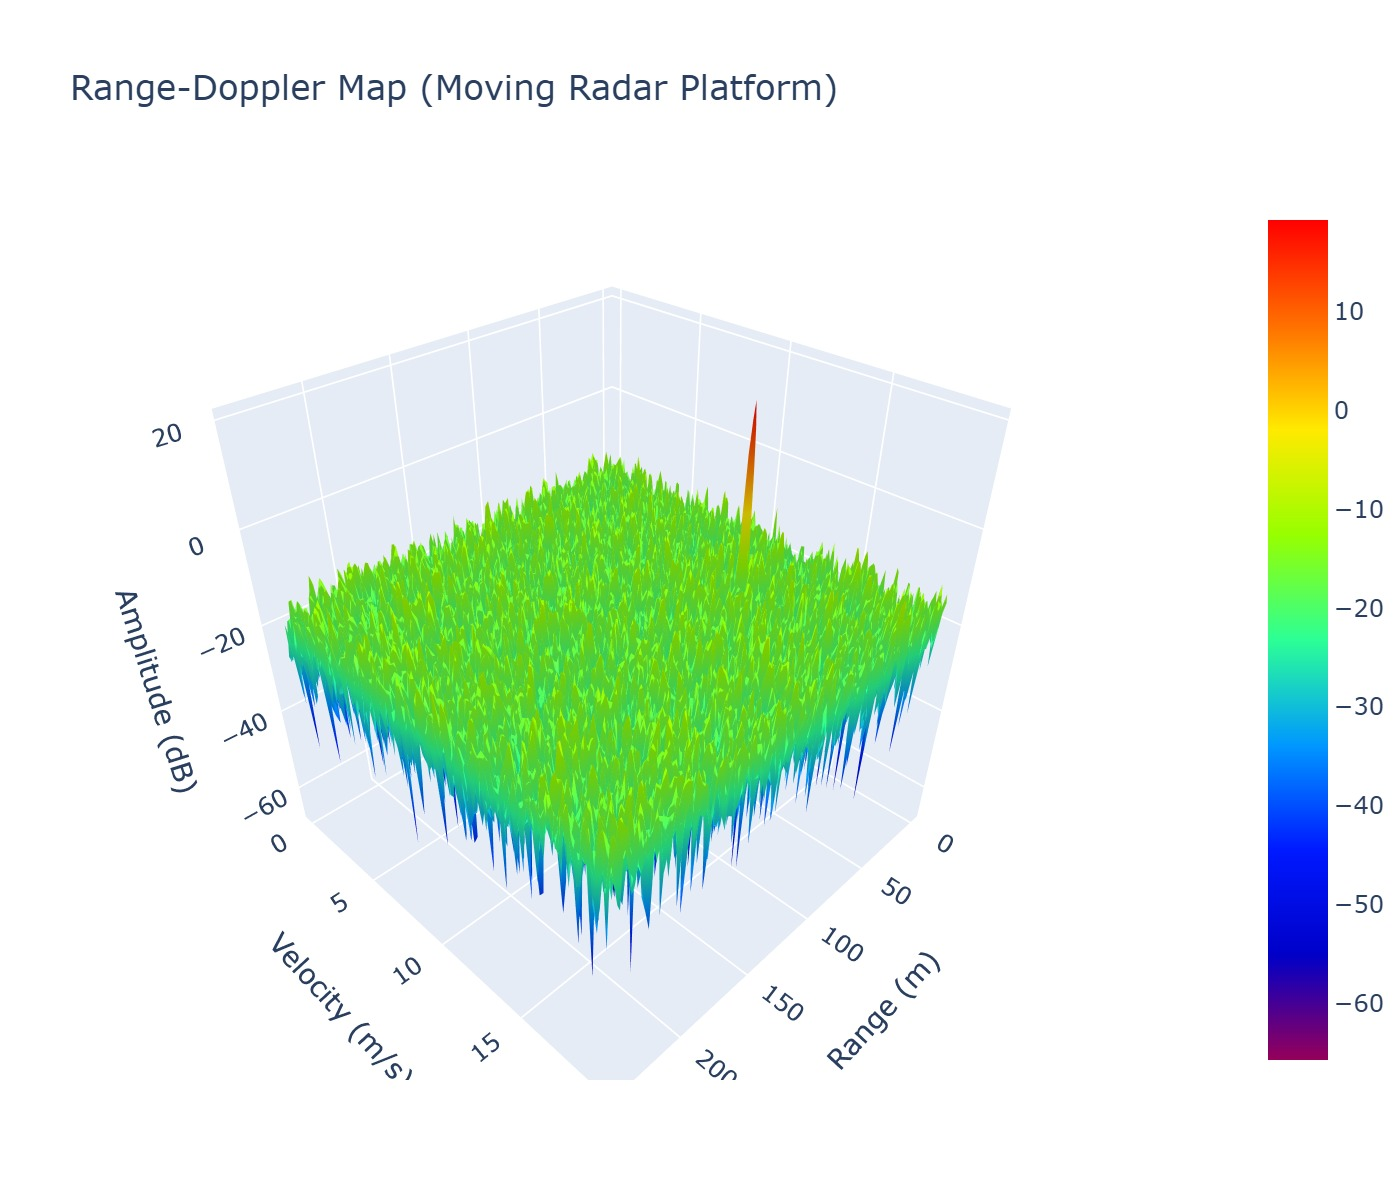

In [ ]:
# Calculate maximum unambiguous range
max_range = (
    3e8  # Speed of light
    * radar.radar_prop["receiver"].bb_prop["fs"]
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]
    / 2
)

# Calculate maximum unambiguous velocity (Doppler)
unambiguous_speed = (
    3e8 / radar.radar_prop["transmitter"].waveform_prop["prp"][0] / 77e9 / 2
)

# Create range axis
range_axis = np.linspace(
    0, max_range, radar.sample_prop["samples_per_pulse"], endpoint=False
)

# Create velocity axis (Doppler)
doppler_axis = np.linspace(
    0,
    unambiguous_speed,
    radar.radar_prop["transmitter"].waveform_prop["pulses"],
    endpoint=False,
)

# Create 3D surface plot
fig = go.Figure()
fig.add_trace(
    go.Surface(
        x=range_axis,
        y=doppler_axis,
        z=20 * np.log10(np.abs(range_doppler[0, :, :])),  # Convert to dB
        colorscale="Rainbow",
    )
)

fig.update_layout(
    title="Range-Doppler Map (Moving Radar Platform)",
    height=600,
    scene=dict(
        xaxis=dict(title="Range (m)"),
        yaxis=dict(title="Velocity (m/s)"),
        zaxis=dict(title="Amplitude (dB)"),
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation="h"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary and Key Takeaways

### What You Learned

This notebook demonstrated how to simulate **arbitrary radar platform motion** using RadarSimPy:

1. **Flexible Motion Planning API**: Used `radar.set_motion(location=(x, y, z), speed=(0, 0, 0))` to define time-varying radar position
2. **Time-sampled trajectories**: Position (and rotation) defined as arrays evaluated at **each sample timestamp** - **not limited to linear motion**
3. **High-fidelity simulation**: Motion is updated at every ADC sample, not just pulse-to-pulse
4. **Arbitrary motion patterns**: Demonstrated how to create linear, sinusoidal, circular, and accelerated trajectories
5. **Rotation support**: Platform orientation can also vary with time using the `rotation` parameter in order **(yaw, pitch, roll)**
6. **Relative motion effects**: Observed how radar motion creates Doppler shifts even for stationary targets
7. **Realistic scenarios**: Simulated automotive/mobile radar applications with moving platforms

### Key Concepts

- **Arbitrary motion support**: RadarSimPy can simulate ANY trajectory expressible as a function of time
- **Sample-level precision**: Motion is evaluated at `radar.time_prop["timestamp"]` for **each ADC sample**, providing high-fidelity simulation
- **Platform motion**: The radar itself can move during observation, common in vehicles, drones, and robots
- **Platform orientation**: Radar can also rotate/pitch/roll during observation using time-varying `rotation` arrays
- **Rotation order**: Rotation is specified as **(yaw, pitch, roll)** in radians
- **Motion planning constraints**: When using time-varying arrays, `speed=(0, 0, 0)` and `rotation_rate=(0, 0, 0)` are required
- **Relative velocity**: Doppler shift depends on relative motion between radar and target
- **Motion signatures**: Stationary targets appear with non-zero Doppler when the radar platform moves
- **Closing vs. opening**: Negative Doppler indicates closing (approaching), positive indicates opening (receding)

### Understanding Motion Flexibility

**The power of `radar.set_motion()`:**

Unlike systems limited to constant velocity, RadarSimPy allows you to define position and rotation as **any mathematical function of time**:

```python
# Linear motion (constant velocity)
location_x = velocity * timestamps

# Sinusoidal motion (oscillation)
location_x = amplitude * np.sin(2 * np.pi * frequency * timestamps)

# Circular motion (rotation)
location_x = radius * np.cos(angular_velocity * timestamps)

# Accelerated motion (changing velocity)
location_x = 0.5 * acceleration * timestamps**2

# Complex combined motion
location_x = v*t + A*sin(ω*t) + 0.5*a*t**2

# Time-varying rotation (e.g., vehicle turning)
rotation_yaw = angular_velocity * timestamps
rotation_pitch = 0 * timestamps
rotation_roll = 0 * timestamps
rotation = (rotation_yaw, rotation_pitch, rotation_roll)  # Order: (yaw, pitch, roll)
```

**Critical Requirement**: When using motion planning arrays:

```python
radar.set_motion(
    location=(location_x, location_y, location_z),  # Time-varying arrays
    speed=(0, 0, 0),  # MUST be (0, 0, 0)
    rotation=(yaw, pitch, roll),  # Optional: time-varying arrays in order (yaw, pitch, roll)
    rotation_rate=(0, 0, 0)  # MUST be (0, 0, 0) if rotation is used
)
```

**Important**: The timestamps array has shape `(frames × channels, pulses, samples_per_pulse)`, and motion is evaluated at every timestamp. This provides:

- Accurate simulation of fast-changing dynamics
- Proper range-dependent phase shifts during motion
- High-fidelity modeling of intra-pulse motion effects
- Correct simulation of platform rotation effects
- Independent motion for each channel (if multi-channel) and frame

This enables realistic simulation of:

- Vehicles with acceleration/braking and turning
- Aircraft performing maneuvers with orientation changes
- Drones following complex flight paths with attitude control
- Vibrating or oscillating platforms
- Multi-frame scenarios with time-evolving motion
- Any dynamic platform motion and orientation scenario

### Understanding the Results in This Example

With linear motion configuration:

- Radar moved at **-12 m/s** along x-axis (in negative x direction, away from target)
- Target was **stationary** at x = 50m (positive x direction)
- Result: Target appeared with **positive Doppler** corresponding to ~12 m/s opening velocity
- The Range-Doppler map correctly captured this relative motion

### Practical Applications

**Automotive Radar:**

- Self-driving cars need to account for their own motion when detecting obstacles
- Platform velocity must be compensated to determine true target velocities
- Acceleration and turning creates complex motion patterns
- Sample-level motion simulation captures vibration effects
- Vehicle rotation during turns affects antenna pointing

**Airborne Radar:**

- Aircraft radar systems must handle high platform velocities
- Ground clutter has large Doppler spread due to platform motion
- Maneuvering aircraft create non-linear motion
- High-fidelity motion simulation is critical at high speeds
- Aircraft attitude changes affect beam pointing and target geometry

**Robotics:**

- Mobile robots use radar for navigation and obstacle avoidance
- Platform motion compensation is essential for accurate velocity estimation
- Robot vibration and dynamic motion affects measurements
- Sample-level updates capture fast dynamics
- Robot orientation changes during maneuvering

### Experiment Further

Try modifying the code to explore different motion patterns:

1. **Sinusoidal motion** (already in code - just uncomment):

   ```python
   location_x = 10 * np.sin(2 * np.pi * timestamps)
   ```

   Observe how oscillating motion creates time-varying Doppler

2. **Circular motion** (uncomment to try):

   ```python
   location_x = 30 + radius * np.cos(angular_freq * timestamps)
   location_y = radius * np.sin(angular_freq * timestamps)
   ```

   See how rotation affects target returns at different angles

3. **Accelerated motion** (uncomment to try):

   ```python
   location_x = 0.5 * acceleration * timestamps**2
   ```

   Watch Doppler shift change as velocity increases

4. **Motion with rotation** (uncomment to try):

   ```python
   location_x = -12 * timestamps
   rotation_yaw = 0.5 * timestamps
   radar.set_motion(
       location=(location_x, 0*timestamps, 0*timestamps),
       rotation=(rotation_yaw, 0*timestamps, 0*timestamps),  # (yaw, pitch, roll)
       speed=(0, 0, 0),
       rotation_rate=(0, 0, 0)
   )
   ```

   Observe how platform rotation affects target visibility and Doppler

5. **Combined patterns** (create your own):

   - Mix linear + sinusoidal for vibrating vehicle motion
   - Add multiple frequency components for complex dynamics
   - Simulate realistic vehicle turning maneuvers with rotation
   - Combine translation and rotation for drone flight paths

6. **Moving targets**:

   - Add velocity to the target: `"speed": (vx, vy, vz)`
   - Observe how combined radar+target motion affects Doppler

7. **Multi-target scenarios**:
   - Add multiple targets at different ranges and angles
   - Observe how motion affects each target differently based on geometry

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- API Reference for `set_motion()`: https://radarsimx.github.io/radarsimpy/radar.html
- Other example notebooks for stationary radar scenarios
